In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal,Empirical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()

## Data Ingestion

In [2]:
# read training data 
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [3]:
# read test data
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
# read ground truth data
truth_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [5]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Preprocessing

In [6]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [7]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [8]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [9]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [10]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [11]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [12]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


## Modelling

In [13]:
# pick a large window size of 50 cycles
sequence_length = 5

In [14]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [15]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [16]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [17]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(20131, 5, 25)

In [18]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [19]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.squeeze(np.concatenate(label_gen).astype(np.float32))
label_array.shape

(20131,)

In [20]:
# target_scaler = MinMaxScaler()
# label_array = np.squeeze(target_scaler.fit_transform(label_array))
# label_array.shape

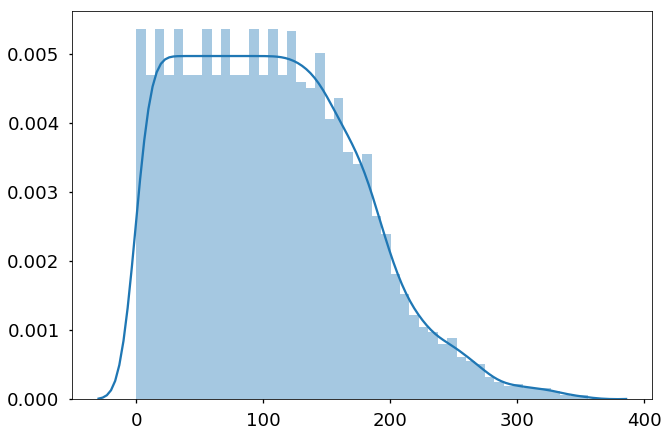

In [21]:
sns.distplot(label_array)

In [22]:
seq_array1,seq_array2,label_array1,label_array2 = train_test_split(seq_array,label_array,test_size=0.9)
#                                                                    ,shuffle=False)

In [23]:
H = 100  # number of hidden units
N,_,D = seq_array1.shape  # number of training data points, number of features
H,N,sequence_length,D

(100, 2013, 5, 25)

## FC
------------------------

In [24]:
def neural_network_with_2_layers(x, W_0, W_1, b_0, b_1):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

dim = 10  # layer dimensions

W_0 = Normal(loc=tf.zeros([D, dim]),
             scale=tf.ones([D, dim]))
W_1 = Normal(loc=tf.zeros([dim, 1]),
             scale=tf.ones([dim, 1]))
b_0 = Normal(loc=tf.zeros(dim),
             scale=tf.ones(dim))
b_1 = Normal(loc=tf.zeros(1),
             scale=tf.ones(1))

x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network_with_2_layers(x, W_0, W_1, b_0, b_1),
           scale=tf.ones(N) * 0.1)  # constant noise

In [25]:
# BACKWARD MODEL A
q_W_0 = Normal(loc=tf.Variable(tf.random_normal([D, dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, dim]))))
q_W_1 = Normal(loc=tf.Variable(tf.random_normal([dim, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, 1]))))
q_b_0 = Normal(loc=tf.Variable(tf.random_normal([dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
q_b_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [26]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={W_0: q_W_0, b_0: q_b_0,
                                 W_1: q_W_1, b_1: q_b_1},
                    data={x: seq_array1[:,sequence_length-1,:], y: label_array1})
inference.run(n_samples=10, n_iter=25000)

25000/25000 [100%] ██████████████████████████████ Elapsed: 88s | Loss: 156788864.000


In [27]:
xp = tf.placeholder(tf.float32,seq_array2[:,sequence_length-1,:].shape)

In [28]:
y_pred = sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]})

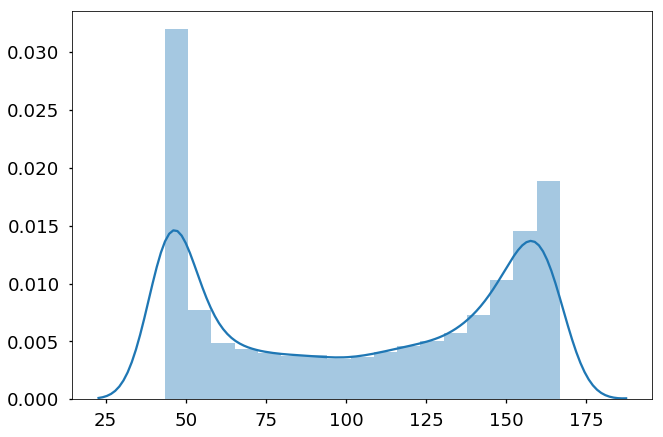

In [29]:
sns.distplot(y_pred)

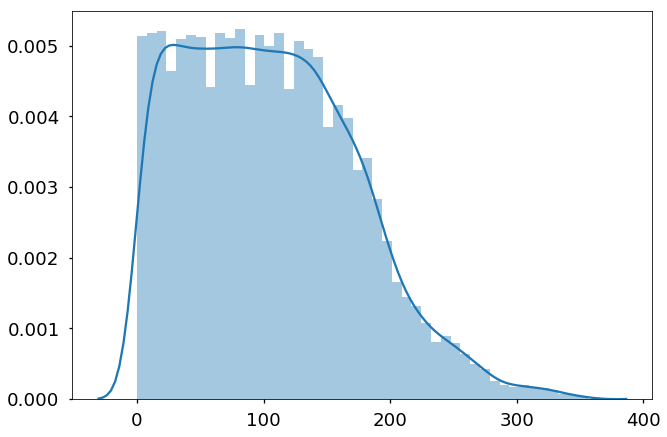

In [30]:
sns.distplot(label_array2)

In [31]:
np.sqrt(mean_squared_error(label_array2,y_pred))

40.952888

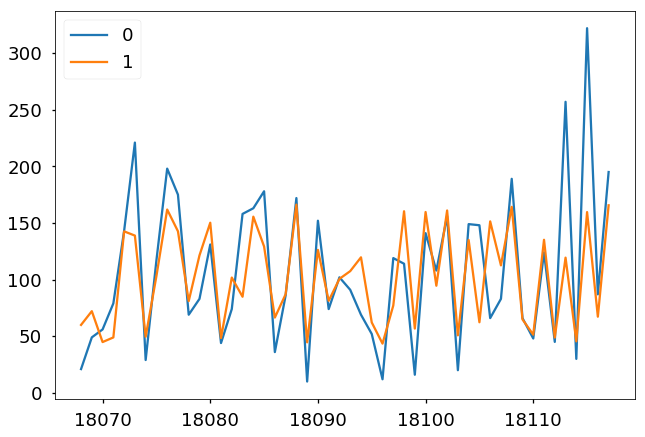

In [32]:
pd.DataFrame([label_array2,y_pred]).transpose()[-50:].plot()

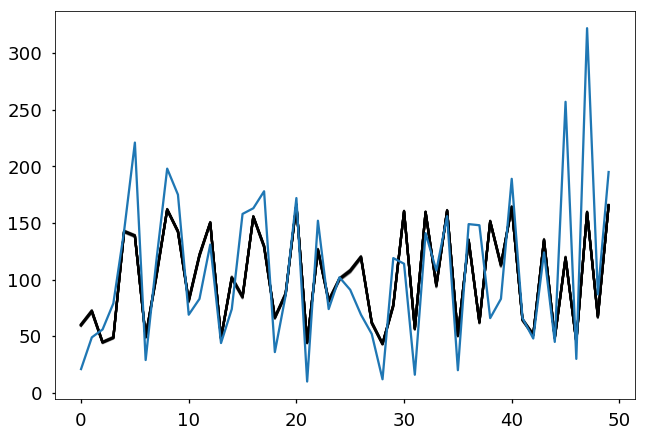

In [33]:
[plt.plot(sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]})[-50:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-50:])

## RNN
-------------------

In [24]:
def rnn_cell_sig(hprev, xt, Wh, Wx, bh):
    return tf.sigmoid(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

def rnn_cell_tanh(hprev, xt, Wh, Wx, bh):
    return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

## Two layer RNN

In [35]:
H1=100
H2=50
def two_rnn_layer(X, Wh1, Wx1, bh1, Wh2, Wx2, bh2, Wy, by, H1, H2):
    N, sequence_length, D = X.get_shape().as_list()
    h1 = tf.zeros([N,H1])
    h2 = tf.zeros([N,H2])
    for i in range(sequence_length):
        h1 = rnn_cell_tanh(h1, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wh1, Wx1, bh1)
        h2 = rnn_cell_tanh(h2, h1, Wh2, Wx2, bh2)
    return tf.reshape(tf.matmul(h2, Wy) + by,[-1])

Wh1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Wx1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wh2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Wx2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wy = Normal(loc=tf.zeros([H2, 1]), scale=tf.ones([H2, 1]))
bh1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bh2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=two_rnn_layer(X, Wh1, Wx1, bh1, Wh2, Wx2, bh2, Wy, by, H1, H2), scale=1.)

In [36]:
# BACKWARD MODEL A
q_Wh1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Wx1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wh2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Wx2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H2, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, 1]))))
q_bh1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bh2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [37]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wh1: q_Wh1, bh1: q_bh1, Wh2: q_Wh2, bh2: q_bh2,
                                 Wx1: q_Wx1, Wx2: q_Wx2, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=10, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 467s | Loss: 1786370.750


In [38]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)

In [39]:
y_pred = sess.run(two_rnn_layer(Xp, q_Wh1, q_Wx1, q_bh1, q_Wh2, q_Wx2, q_bh2, q_Wy, q_by, H1, H2),{Xp:seq_array2})

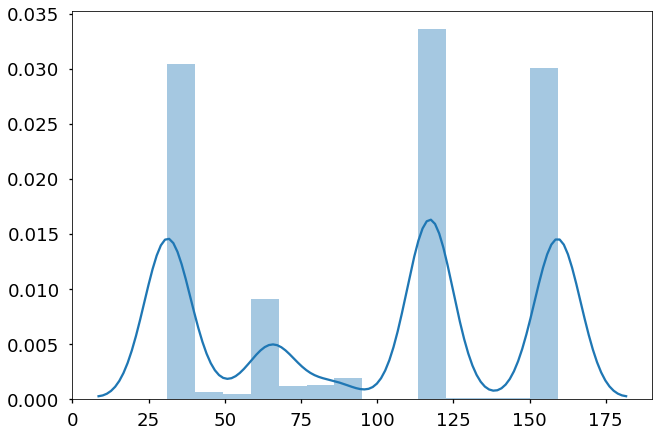

In [40]:
sns.distplot(y_pred)

In [41]:
np.sqrt(mean_squared_error(label_array2,y_pred))

42.809109

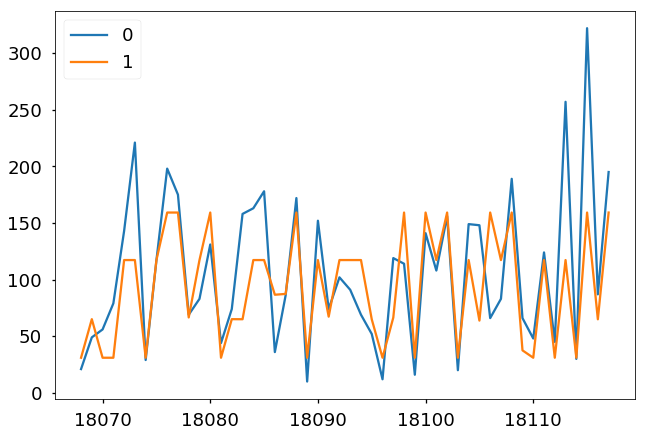

In [42]:
pd.DataFrame([label_array2,y_pred]).transpose()[-50:].plot()

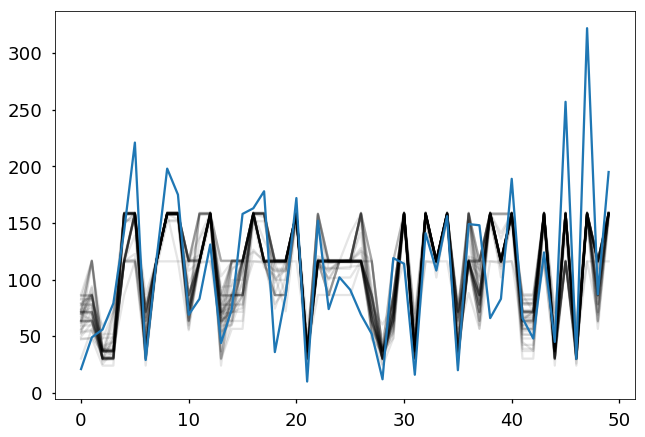

In [43]:
[plt.plot(sess.run(two_rnn_layer(Xp, q_Wh1, q_Wx1, q_bh1, q_Wh2, q_Wx2, q_bh2, q_Wy, q_by, H1, H2),{Xp:seq_array2})[-50:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-50:])

## Two-layer LSTM
-----------------

In [25]:
H1 = 100
H2 = 50

def LSTM_cell(hprev, cprev, xt, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc):
    f = rnn_cell_sig(hprev,xt,Wf,Uf,bf)
    i = rnn_cell_sig(hprev,xt,Wi,Ui,bi)
    o = rnn_cell_sig(hprev,xt,Wo,Uo,bo)
    c = f*cprev + i*rnn_cell_tanh(hprev,xt,Wc,Uc,bc)
    h = o*tf.tanh(c)
    return h,c

def LSTM_layer(X, Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1, 
               Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2, Wy, by, H1, H2):
    N, sequence_length, D = X.get_shape().as_list()
    h1 = tf.zeros([N,H1])
    c1 = tf.zeros([N,H1])
    h2 = tf.zeros([N,H2])
    c2 = tf.zeros([N,H2])
    for i in range(sequence_length):
        h1,c1 = LSTM_cell(h1, c1, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), 
                          Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1)
        h2,c2 = LSTM_cell(h2, c2, h1, 
                          Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2)
        
    return tf.reshape(tf.matmul(h2, Wy) + by,[-1])


Wf1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uf1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wi1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Ui1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wo1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uo1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wc1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uc1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))

Wf2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uf2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wi2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Ui2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wo2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uo2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wc2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uc2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))

Wy = Normal(loc=tf.zeros([H2, 1]), scale=tf.ones([H2, 1]))
bf1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bi1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bo1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bc1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bf2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bi2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bo2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bc2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=LSTM_layer(X, Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1, 
               Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2, Wy, by, H1, H2), scale=1.)

## BBVI

In [30]:
# BACKWARD MODEL A
q_Wf1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uf1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wi1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Ui1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wo1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uo1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wc1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uc1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))

q_Wf2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uf2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wi2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Ui2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wo2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uo2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wc2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uc2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))

q_Wy = Normal(loc=tf.Variable(tf.random_normal([H2, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, 1]))))
q_bf1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bi1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bo1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bc1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bf2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bi2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bo2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bc2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [31]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wf1: q_Wf1, Uf1: q_Uf1, Wi1: q_Wi1, Ui1: q_Ui1, 
                                 Wo1: q_Wo1, Uo1: q_Uo1, Wc1: q_Wc1, Uc1: q_Uc1,
                                 Wf2: q_Wf2, Uf2: q_Uf2, Wi2: q_Wi2, Ui2: q_Ui2, 
                                 Wo2: q_Wo2, Uo2: q_Uo2, Wc2: q_Wc2, Uc2: q_Uc2,
                                 bf1: q_bf1, bi1: q_bi1, bo1: q_bo1, bc1: q_bc1, 
                                 bf2: q_bf2, bi2: q_bi2, bo2: q_bo2, bc2: q_bc2,
                                 Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=10, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 2077s | Loss: 649974.938


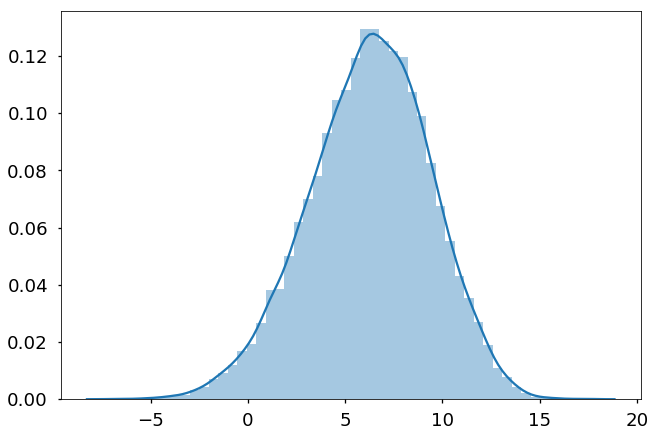

In [32]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(LSTM_layer(Xp, Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1, 
               Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2, Wy, by, H1, H2),{Xp:seq_array2})
sns.distplot(y_pred)

In [33]:
np.sqrt(mean_squared_error(label_array2,y_pred))

120.21334

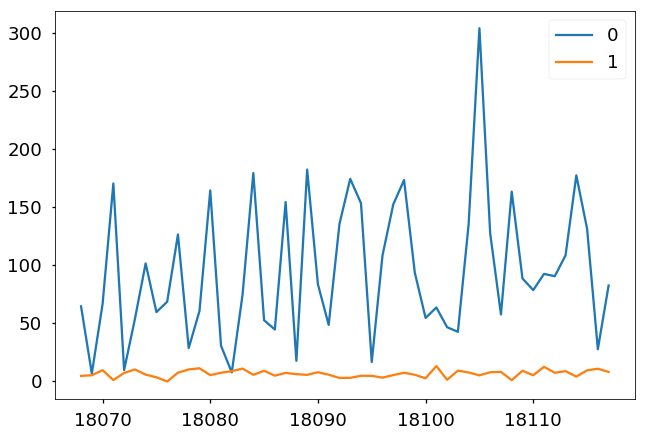

In [34]:
pd.DataFrame([label_array2,y_pred]).transpose()[-50:].plot()

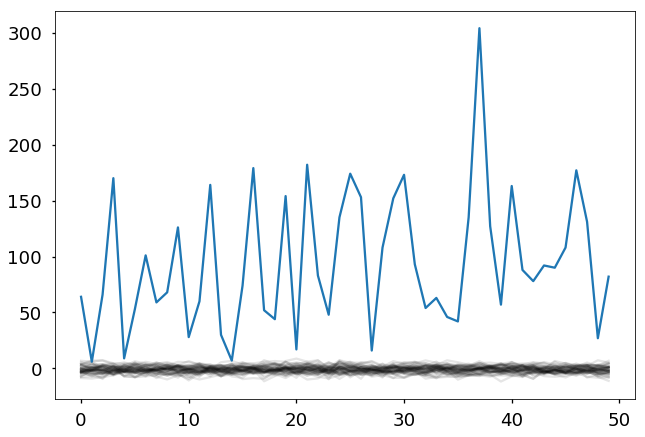

In [36]:
[plt.plot(sess.run(LSTM_layer(Xp, Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1, 
               Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2, Wy, by, H1, H2),{Xp:seq_array2})[-50:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-50:])

## Two-layer GRU
-----------------

In [37]:
H1 = 100
H2 = 50

def GRU_cell(hprev, xt, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh):
    z = rnn_cell_sig(hprev,xt,Wz,Uz,bz)
    r = rnn_cell_sig(hprev,xt,Wr,Ur,br)
    h = z*hprev + (1-z)*rnn_cell_tanh(r*hprev,xt,Wh,Uh,bh)
    return h

def GRU_layer(X, Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1, 
              Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2, Wy, by, H1,H2):
    N, sequence_length, D = X.get_shape().as_list()
    h1 = tf.zeros([N,H1])
    h2 = tf.zeros([N,H2])
    for i in range(sequence_length):
        h1 = GRU_cell(h1, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1)
        h2 = GRU_cell(h2, h1, Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2)
    return tf.reshape(tf.matmul(h2, Wy) + by,[-1])


Wz1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uz1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wr1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Ur1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wh1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uh1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))

Wz2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uz2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wr2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Ur2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wh2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uh2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))

Wy = Normal(loc=tf.zeros([H2, 1]), scale=tf.ones([H2, 1]))
bz1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
br1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bh1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bz2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
br2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bh2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=GRU_layer(X, Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1, 
              Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2, Wy, by, H1,H2), scale=1.)

## BBVI

In [38]:
# BACKWARD MODEL A
q_Wz1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uz1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wr1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Ur1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wh1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uh1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))

q_Wz2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uz2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wr2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Ur2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wh2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uh2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))

q_Wy = Normal(loc=tf.Variable(tf.random_normal([H2, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, 1]))))
q_bz1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_br1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bh1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bz2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_br2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bh2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [39]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wz1: q_Wz1, Uz1: q_Uz1, Wr1: q_Wr1, Ur1: q_Ur1, Wh1: q_Wh1, Uh1: q_Uh1,
                                 Wz2: q_Wz2, Uz2: q_Uz2, Wr2: q_Wr2, Ur2: q_Ur2, Wh2: q_Wh2, Uh2: q_Uh2,
                                 bz1: q_bz1, bz1: q_bz1, bh1: q_bh1, 
                                 bz2: q_bz2, bz2: q_bz2, bh2: q_bh2, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=10, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 1729s | Loss: 1129546.875


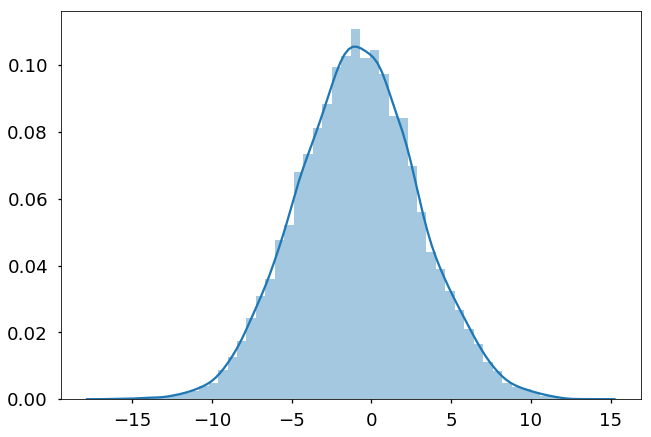

In [40]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_pred = sess.run(GRU_layer(Xp, Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1, 
              Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2, Wy, by, H1,H2),{Xp:seq_array2})
sns.distplot(y_pred)

In [41]:
np.sqrt(mean_squared_error(label_array2,y_pred))

125.43483

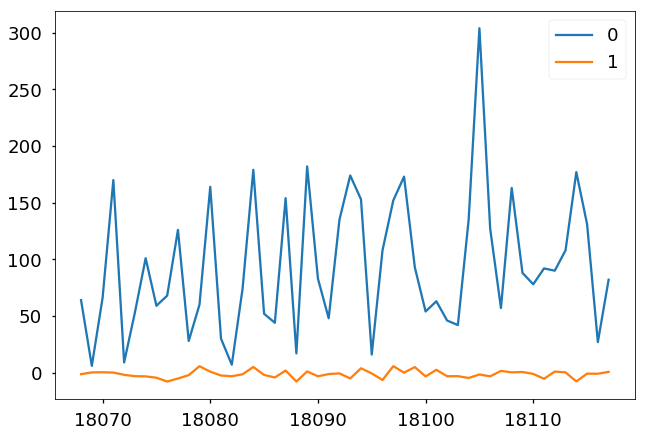

In [42]:
pd.DataFrame([label_array2,y_pred]).transpose()[-50:].plot()

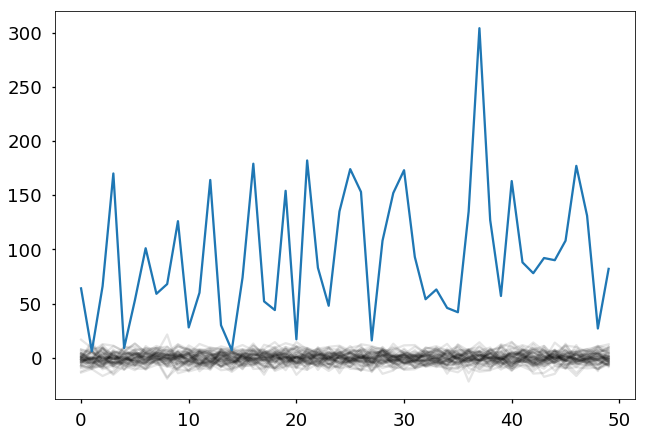

In [43]:
[plt.plot(sess.run(GRU_layer(Xp, Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1, 
              Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2, Wy, by, H1,H2),{Xp:seq_array2})[-50:],
         color='black', alpha=0.1) for _ in range(50)]
plt.plot(label_array2[-50:])